In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [80]:
#Loading datasets
df_us = pd.read_csv('../../data/raw/GEE_Maize_Data_us_cornbelt.csv')
df_argen = pd.read_csv('../../data/raw/GEE_Maize_Data_argentina_pampas.csv')
df_brazil = pd.read_csv('../../data/raw/GEE_Maize_Data_brazil_mato_grosso.csv')
df_india = pd.read_csv('../../data/raw/GEE_Maize_Data_india_uttar_pradesh.csv')

#merging the datasets together
df = pd.concat([df_argen, df_brazil, df_us, df_india])
df.shape

(56240, 15)

In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56240 entries, 0 to 20071
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   system:index  56240 non-null  object 
 1   B11           56240 non-null  int64  
 2   B12           56240 non-null  int64  
 3   B2            56240 non-null  int64  
 4   B3            56240 non-null  int64  
 5   B4            56240 non-null  int64  
 6   B5            56240 non-null  int64  
 7   B8            56240 non-null  int64  
 8   EVI           56240 non-null  float64
 9   GNDVI         56240 non-null  float64
 10  NDRE          56240 non-null  float64
 11  NDVI          56240 non-null  float64
 12  SAVI          56240 non-null  float64
 13  date          56240 non-null  float64
 14  .geo          56240 non-null  object 
dtypes: float64(6), int64(7), object(2)
memory usage: 6.9+ MB


In [82]:
# Clean up columns and convert date
df = df.rename(columns={'system:index': 'system_index', '.geo': 'geometry'})
df['date'] = pd.to_datetime(df['date'], unit='ms')

# Calculating some more indices
df['NDMI'] = (df['B8'] - df['B11']) / (df['B8'] + df['B11'])
df['MSAVI'] = ((2 * df['B8'] + 1) - np.sqrt(np.pow((2 * df['B8'] + 1), 2) - 8 * (df['B8'] - df['B4']))) / 2

In [83]:
# Filteringout invalid points
modified_df = df[df['NDVI'] > 0]

In [84]:
aggs = {
    'B8': 'mean',
    'B11': 'mean', 
    'B12': 'mean',
    'B2': 'mean', 
    'B3': 'mean',
    'B4': 'mean', 
    'B5': 'mean',
    'EVI': 'mean', 
    'GNDVI': 'mean',
    'NDRE': 'mean', 
    'NDVI': 'mean', 
    'SAVI': 'mean',
    'MSAVI': 'mean', 
    'NDMI': 'mean'
}

updated_df = modified_df.groupby('geometry').agg(aggs)
updated_df.head()

,B8,B11,B12,B2,B3,B4,B5,EVI,GNDVI,NDRE,NDVI,SAVI,MSAVI,NDMI
geometry,,,,,,,,,,,,,,
"{""geodesic"":false,""type"":""Point"",""coordinates"":[-55.99975724605936,-10.036863316938634]}",2592.76,3597.02,2211.08,565.82,831.26,1011.18,1459.94,0.977091,0.511852,0.275444,0.434972,0.652367,0.597806,-0.162997
"{""geodesic"":false,""type"":""Point"",""coordinates"":[-56.002039654992814,-10.036418029640528]}",2693.46,3724.58,2340.06,761.14,1010.96,1165.26,1671.14,0.873051,0.489982,0.249000,0.423688,0.635443,0.582853,-0.166965
"{""geodesic"":false,""type"":""Point"",""coordinates"":[-56.002770412335906,-10.036148929791462]}",2629.76,3620.94,2255.34,710.68,962.26,1115.38,1593.10,0.833118,0.490973,0.256016,0.424421,0.636541,0.584807,-0.163460
"{""geodesic"":false,""type"":""Point"",""coordinates"":[-56.003043858077234,-10.036240184411483]}",2753.80,3963.36,2566.10,788.38,1084.22,1356.28,1840.86,0.621063,0.461155,0.209325,0.357291,0.535867,0.517407,-0.183240
"{""geodesic"":false,""type"":""Point"",""coordinates"":[-56.005687359815894,-10.037062013625198]}",2471.68,3624.88,2296.38,615.58,869.40,1127.14,1560.66,0.810101,0.478209,0.225010,0.375069,0.562525,0.536555,-0.185071


In [85]:
def infer_maize_growth_stage(row: pd.Series) -> str:
    """
    Infres the growth stage of maize using a highly robust set of rules based on
    all seven available vegetation indices (NDVI, NDRE, EVI, GNDVI, SAVI, NDMI, MSAVI).
    
    Args:
        row (pd.Series): A row of data containing the time-series vegetation indices.
        
    Returns:
        str: Inferred growth stage ('emergence', 'vegetative', 'reproductive', 'maturation', 'dormant').
    """
    # Access all 7 indices, providing a default of 0 to prevent KeyError
    ndvi = row.get('NDVI', 0)
    ndre = row.get('NDRE', 0)
    msavi = row.get('MSAVI', 0)
    evi = row.get('EVI', 0)
    gndvi = row.get('GNDVI', 0)
    savi = row.get('SAVI', 0)
    ndmi = row.get('NDMI', 0)
    
    # Use a small constant to prevent division by zero in ratios
    EPSILON = 1e-9 
    
    # Ratio indicating loss of chlorophyll (NDRE drops faster than NDVI during decay)
    red_edge_ratio = ndre / (ndvi + EPSILON) 
    
    # 1. DORMANT / FALLOW (Before planting or after harvest)
    if ndvi < 0.1 and evi < 0.1 and msavi < 0.1:
        return 'dormant'

    # 2. MATURATION / SENESCENCE (Decay begins)
    if ndvi >= 0.4 and red_edge_ratio < 0.65 and gndvi < 0.55:
        return 'maturation'

    # 3. REPRODUCTIVE / PEAK VIGOR (Maximum canopy closure and health)
    elif ndvi >= 0.75 and evi >= 0.6 and ndre >= 0.35 and gndvi >= 0.65:
        # High confidence for peak biomass and photosynthetic activity
        return 'reproductive'

    # 4. VEGETATIVE (Rapid growth phase)
    elif ndvi >= 0.5 and evi >= 0.4 and msavi >= 0.4:
        return 'vegetative'

    # 5. EMERGENCE / EARLY VEGETATIVE (Establishment)
    elif ndvi > 0.1 and msavi < 0.4 and ndre < 0.2 and savi < 0.4:
        return 'emergence'

    else:
        # Fallback for highly stressed or anomalous data points
        return 'uncertain_vegetative'


In [86]:
def assess_maize_health(row: pd.Series, growth_stage: str) -> int:
    """
    Assesses maize health (1: Healthy, 0: Unhealthy) based on domain-knowledge 
    thresholds for all seven vegetation indices, specific to the inferred growth stage.
    
    Args:
        row (pd.Series): A row of time-series data containing the vegetation indices.
        growth_stage (str): The inferred growth stage from 'infer_maize_growth_stage_refined'.
    
    Returns:
        int: Health classification (1 = healthy, 0 = unhealthy).
    """
    # Access all 7 indices, providing a default of 0
    ndvi = row.get('NDVI', 0)
    ndre = row.get('NDRE', 0)
    msavi = row.get('MSAVI', 0)
    ndmi = row.get('NDMI', 0)
    evi = row.get('EVI', 0)
    gndvi = row.get('GNDVI', 0)
    savi = row.get('SAVI', 0)
    
    # --- Health Status Logic (0 = Unhealthy, 1 = Healthy) ---
    
    if growth_stage == 'dormant':
        # Dormant phase is expected to be low vigor. Anomaly is high NDVI in this period.
        if ndvi > 0.15:
            return 0  # Unhealthy (Anomaly/Weeds)
        return 1     

    elif growth_stage == 'emergence':
        # Critical phase: Is the crop established? MSAVI/SAVI must show initial ground cover.
        if msavi < 0.15 or savi < 0.15 or ndmi < -0.1:
            return 0  
        return 1      

    elif growth_stage == 'vegetative':
        # Focus on the rate of growth and potential water stress (NDMI) and chlorophyll/structure (NDRE/EVI)
        if ndvi < 0.45 or ndre < 0.2 or evi < 0.35 or gndvi < 0.4 or ndmi < 0.05:
            return 0  
        return 1      
            
    elif growth_stage == 'reproductive':
        # Peak phase: Highest thresholds required across all metrics.
        # Requires high NDVI (biomass), high EVI (structure), high NDRE (health), and acceptable NDMI (water).
        if ndvi < 0.7 or evi < 0.55 or ndre < 0.35 or gndvi < 0.65 or ndmi < 0.15:
            return 0  
        return 1      
            
    elif growth_stage == 'maturation':
        # Senescence phase: Look for premature collapse or anomalous high vigor with low health.
        
        # Scenario 1: Premature collapse (e.g., extreme drought/early harvest)
        if ndvi < 0.3 or evi < 0.2:
             return 0
             
        # Scenario 2: High biomass but low chlorophyll/health (disease or nutrient issue)
        if (ndvi > 0.6 and ndre < 0.2) or (evi > 0.5 and gndvi < 0.3):
            return 0  
            
        return 1       
    
    elif growth_stage == 'uncertain_vegetative':
        # Conservative check for mid-season uncertainty. If vigor is clearly low, flag it.
        if ndvi < 0.5 or evi < 0.4:
            return 0  
        return 1      
    
    # Default case (Unknown or unhandled growth_stage)
    return 0 

In [87]:
def process_maize_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Processes the DataFrame to add growth stage and health classification.
    
    Args:
        df (pd.DataFrame): Input DataFrame with vegetation indices.
    
    Returns:
        pd.DataFrame: DataFrame with added 'inferred_stage' and 'health_status' columns.
    """
    result_df = df.copy()
    
    # Step 1: Infer growth stage for each geometry/observation
    result_df['inferred_stage'] = result_df.apply(infer_maize_growth_stage, axis=1)
    
    # Step 2: Assess health based on the inferred stage
    result_df['health_status'] = result_df.apply(
        lambda row: assess_maize_health(row, row['inferred_stage']), axis=1
    )
    
    return result_df

In [88]:
# Process the data
classified_df = process_maize_data(updated_df)

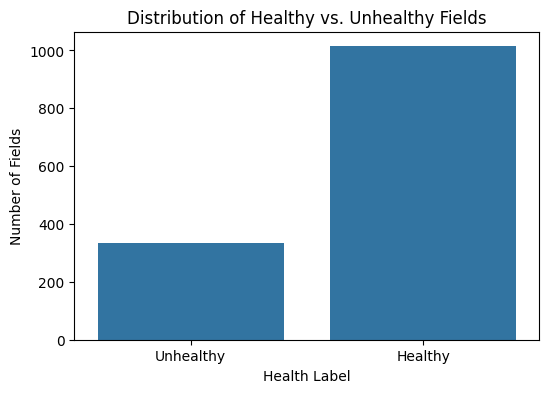

In [89]:
plt.figure(figsize=(6, 4))
sns.countplot(x=classified_df['health_status'], data=classified_df)
plt.title('Distribution of Healthy vs. Unhealthy Fields')
plt.xlabel('Health Label')
plt.ylabel('Number of Fields')
plt.xticks([1, 0], ['Healthy', 'Unhealthy'])
plt.show()

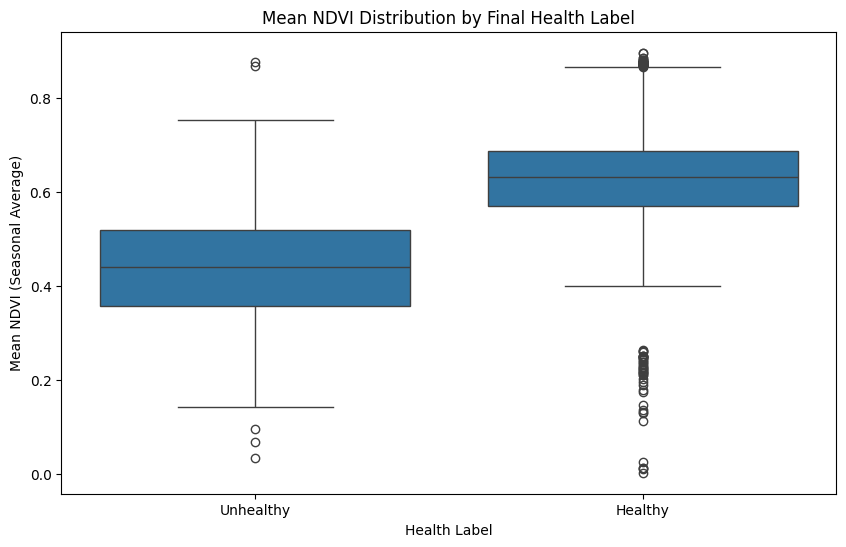

In [90]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=classified_df['health_status'], y=classified_df['NDVI'], data=classified_df)
plt.title('Mean NDVI Distribution by Final Health Label')
plt.xlabel('Health Label')
plt.ylabel('Mean NDVI (Seasonal Average)')
plt.xticks([1, 0], ['Healthy', 'Unhealthy'])
plt.show()

In [ ]:
classified_df.to_csv('../../data/processed/classiied_maize_data.csv', index=False)


: 

In [ ]:
classified_df

: 